In [2]:
#import necessary labraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display


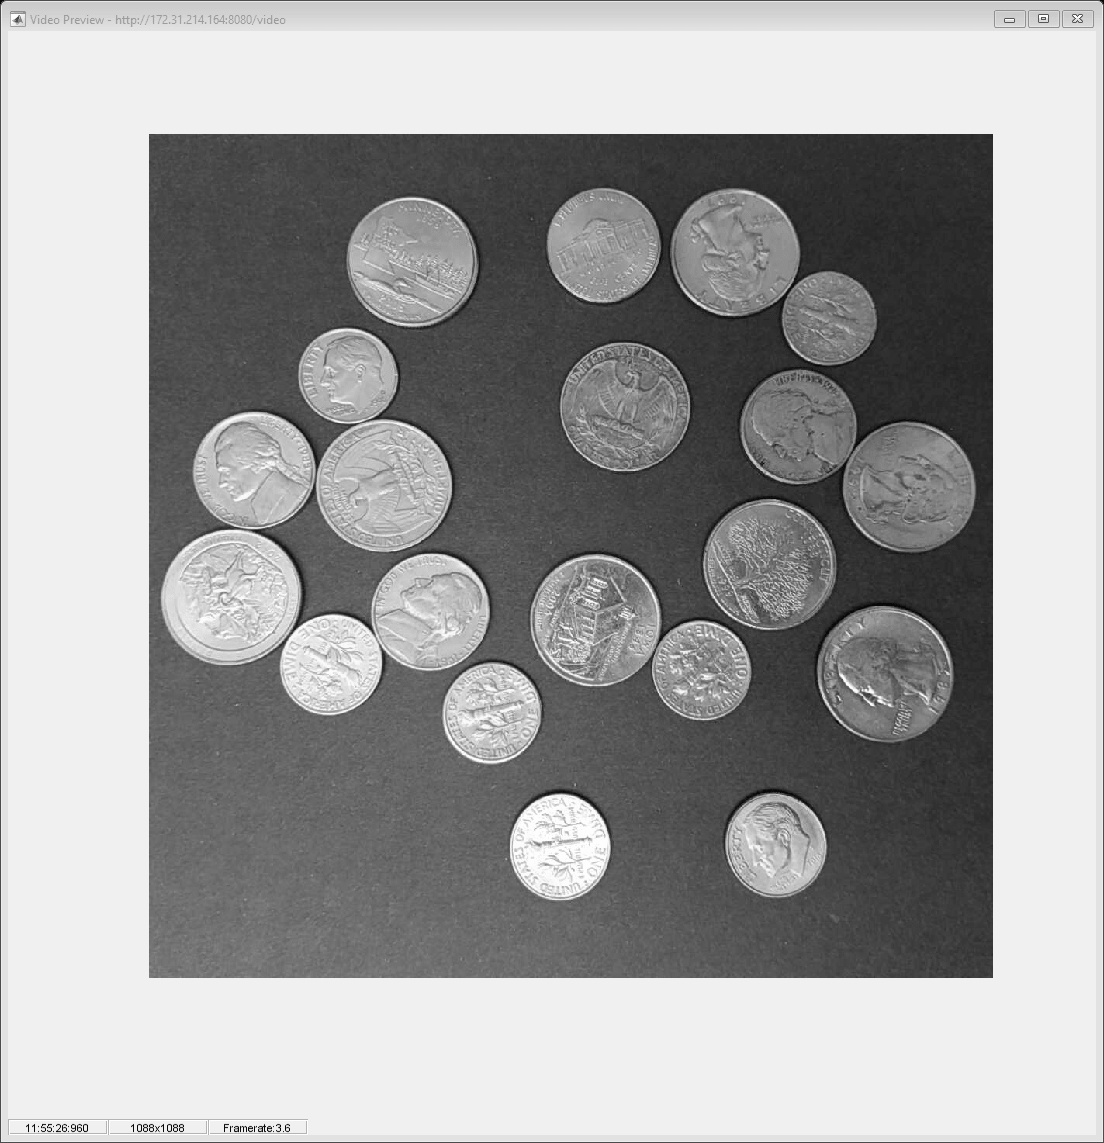

In [12]:
def imshow(img, axes=None):
    if axes is None:
        ret, encoded = cv2.imencode('.jpg', img)
        display(Image(encoded))
    else:
        axes.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes.axis('off')

img = cv2.imread('Coins.png')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

imshow(gray)


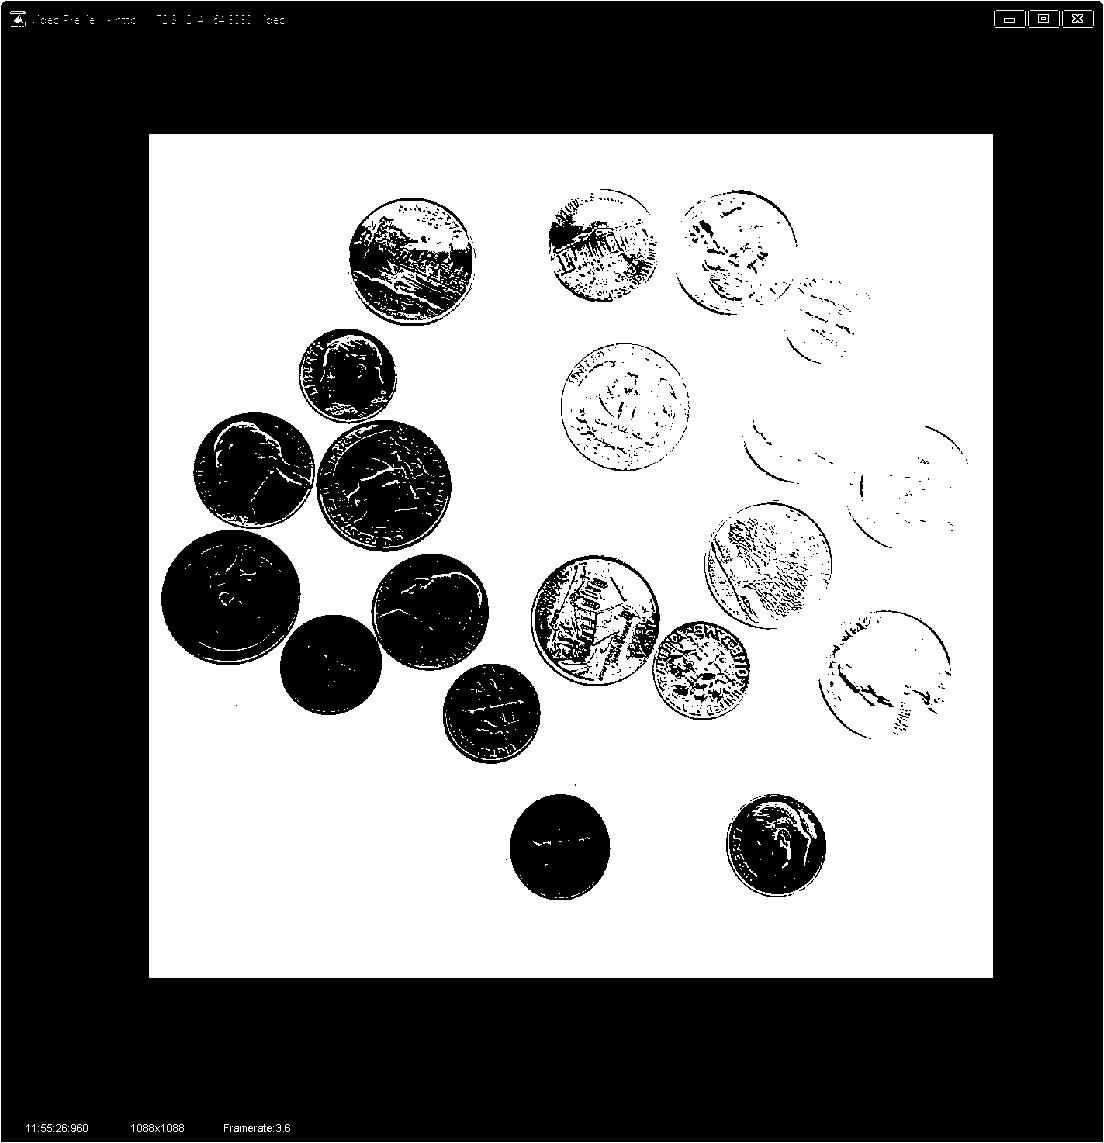

In [13]:
ret, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

imshow(bin_img)

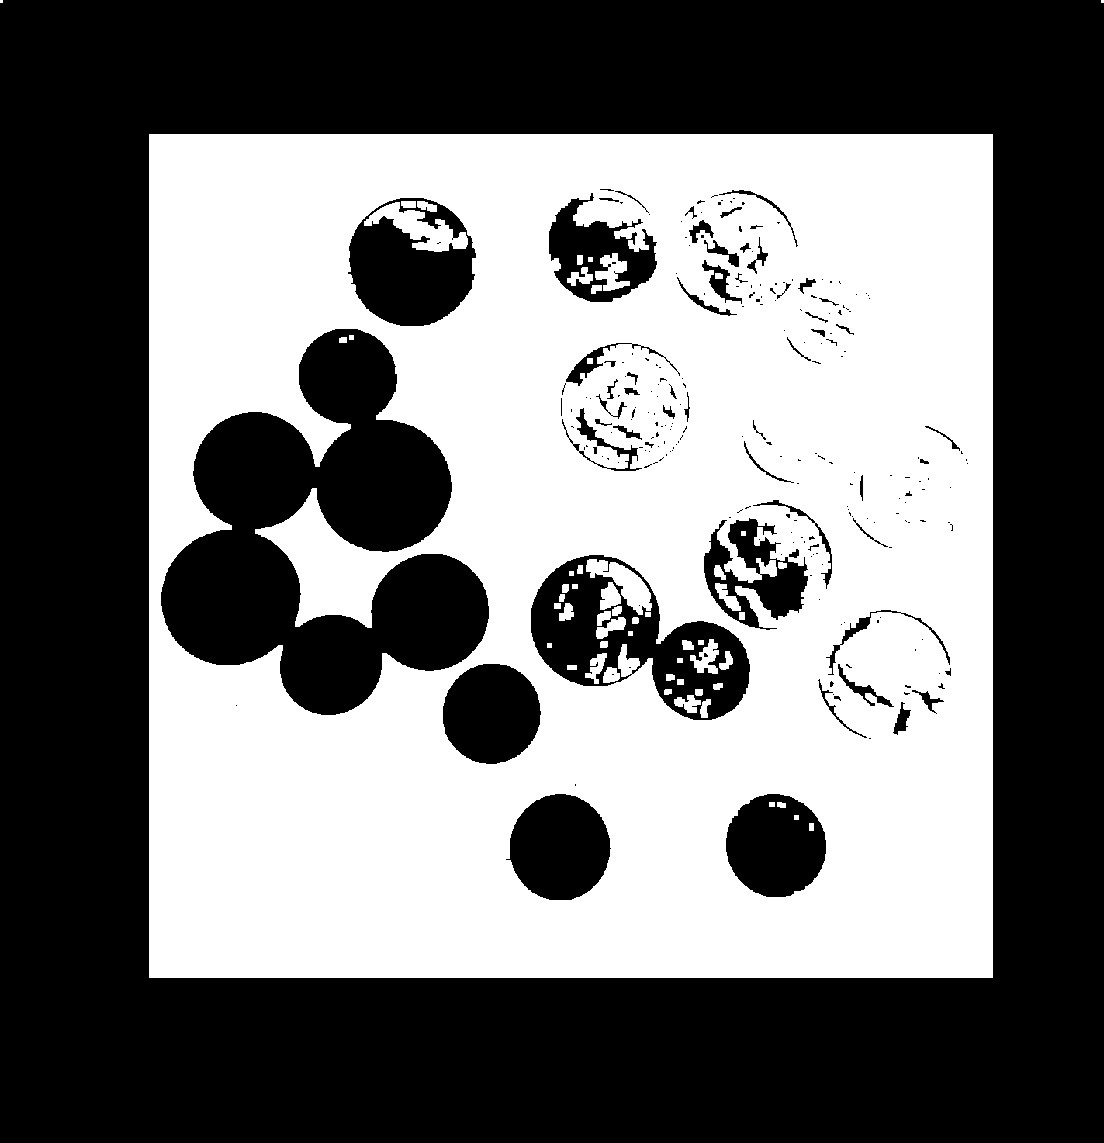

In [14]:
# noise removal 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)

imshow(bin_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


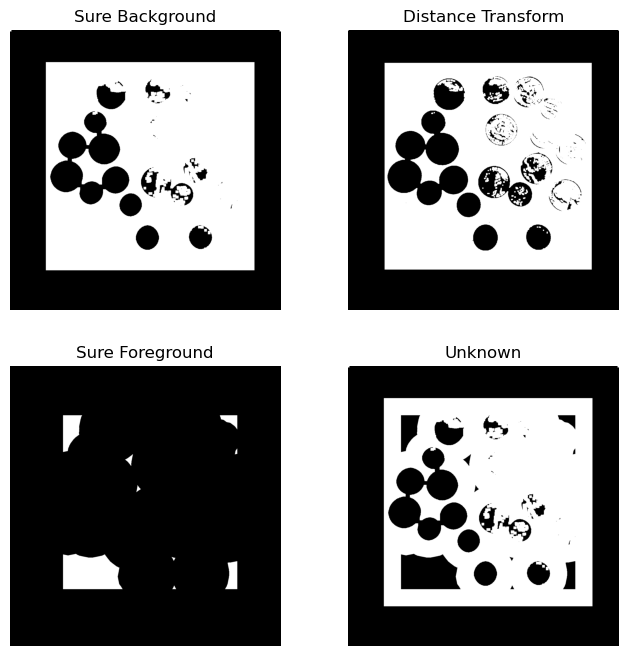

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
#sure bg
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
imshow(sure_bg, axes[0, 0])
axes[0, 0].set_title('Sure Background')


# Distance transform 
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist, axes[0, 1])
axes[0, 1].set_title('Distance Transform')


ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
imshow(sure_fg, axes[1, 0])
axes[1, 0].set_title('Sure Foreground')

unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1, 1])
axes[1, 1].set_title('Unknown')
plt.show()


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


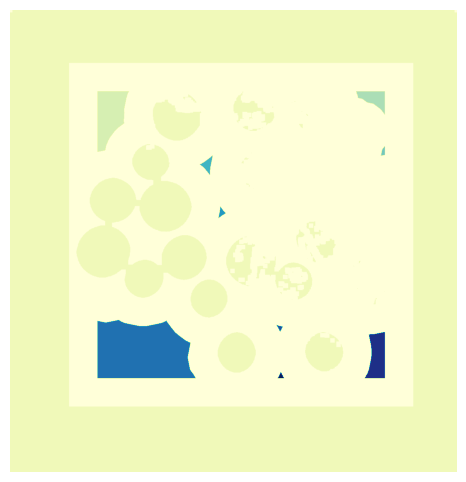

In [16]:
# Marker labelling 
# sure foreground  
ret, markers = cv2.connectedComponents(sure_fg)
print(markers)

# Add one to all labels so that background is not 0, but 1 
markers += 1
# mark the region of unknown with zero 
markers[unknown == 255] = 0

fig,ax = plt.subplots(figsize=(6, 6,))
#ax.imshow(markers, cmap="tab20b") 
ax.imshow(markers, cmap='YlGnBu')
ax.axis('off')
plt.show()

### Watershed Algo

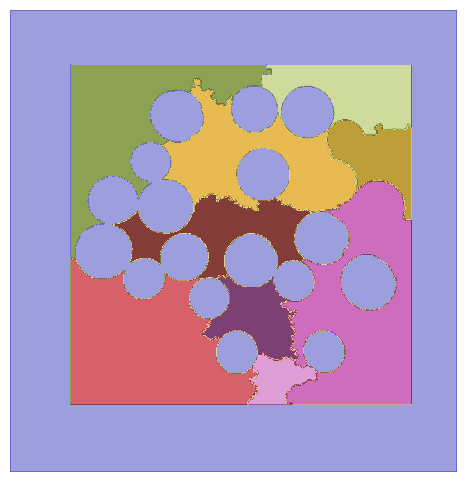

In [17]:
# watershed Algorithm 
markers = cv2.watershed(img, markers)

fig,ax = plt.subplots(figsize=(6, 6,))
ax.imshow(markers, cmap="tab20b") 
#ax.imshow(markers, cmap='YlGnBu')
ax.axis('off')
plt.show()

In [18]:
labels = np.unique(markers)
print(labels)

[-1  1  2  3  4  5  6  7  8  9 10]


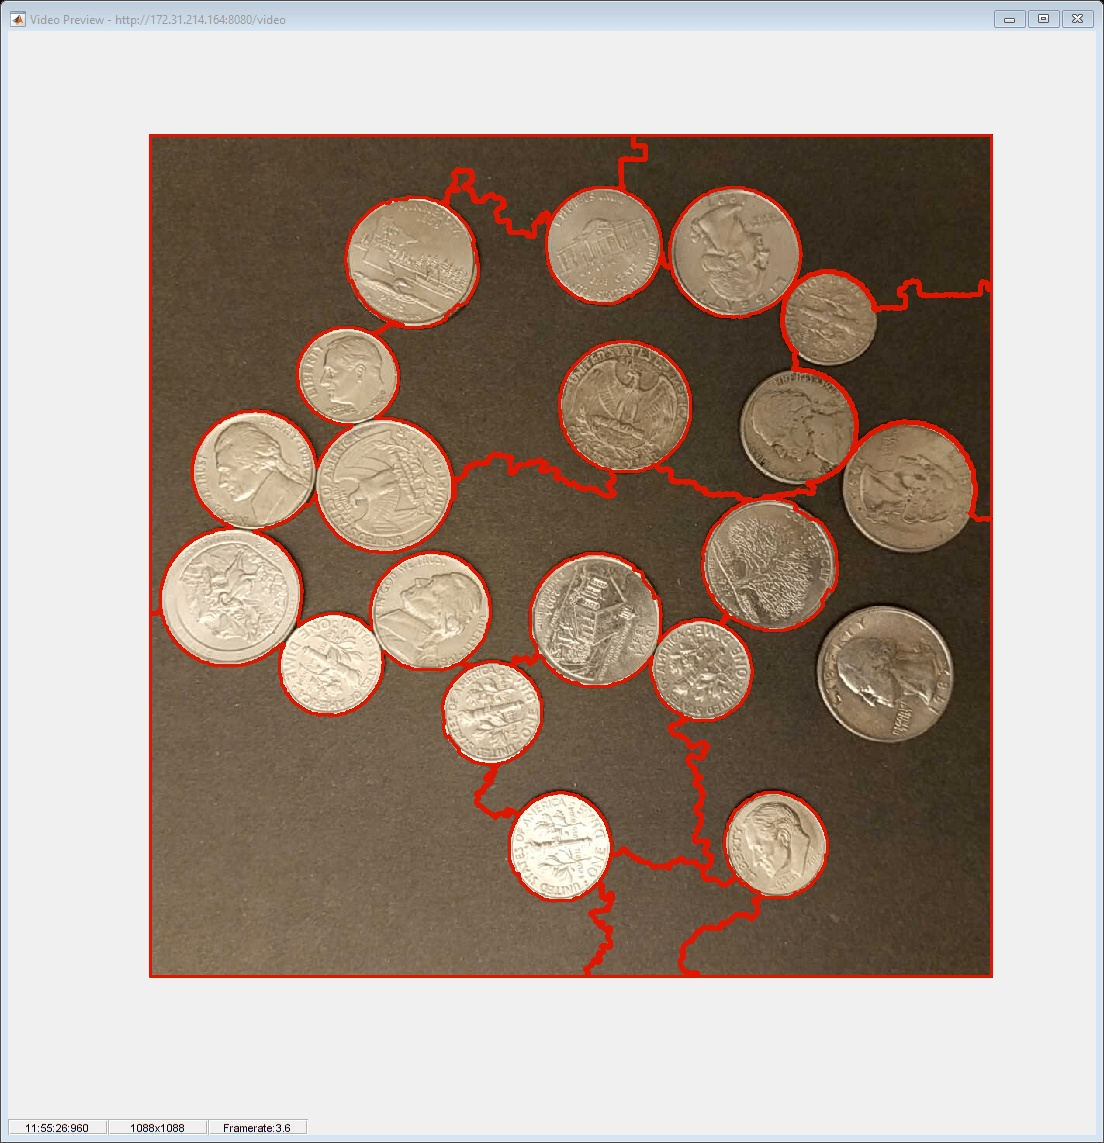

In [19]:
coins = []
for label in labels[2:]:
     
    # Create a binary image in which only the area of the label is in the foreground  
    #and the rest of the image is in the background 
    target = np.where(markers == label, 255, 0).astype(np.uint8)
    
    # Perform contour extraction on the created binary image 
    contour, heirarchy = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coins.append(contour[0])

cv2.drawContours(img, coins, -1, color=(0, 23, 223), thickness=2)
imshow(img)
